In [76]:
"""
Created on Sun Jan 5 18:35 2019

@author: Soeren Brandt
"""

# import our modules
import fra_expt

#import some generally useful modules
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [77]:
segmentcolors = [(.8, 0, 0), (0, .8, 0), (0, 0, .8)]
color = {"train": [0.5, 0.5, 0.5], "test": [0, 0, 0]}

pentane_blue = (69./255, 127./255, 181./255)
hexane_orange = (238./255, 124./255, 48./255)
octane_red = (192./255, 46./255, 38./255)

labelsize = 13
ticksize = 12
legendsize = 12

#### Functions

In [109]:
from plot_functions import get_colors, plot_deriv, get_gradient_colors, get_markers
import colorsys

C_val = 1e1
gamma_val = 1.5e0

def plot_derivs(exp_derivs, exp_lbl, c2, c1 = pentane_blue, ax = None):
    all_lbls = sorted(list(set(exp_lbl.values())))

    # averages
    if ax == None:
        fig, ax = plt.subplots()

    maximum = 0
    colorset = get_colors(4)
    #face_color = np.flip(get_gradient_colors(len(all_lbls), colorset[0], colorset[-1]), axis = 0) # unique face color for each chemical in data set
    face_color = np.flip(get_gradient_colors(len(all_lbls), c1, c2), axis = 0)
    markers = get_markers(len(all_lbls))
    for n, lbl in enumerate(all_lbls):
        if lbl not in [100,200]:#[0.2, 0.4, 0.6, 0.8] + [0.25, 0.33, 0.67, 0.75]:
            # get phase derivatives
            nums = [key for key in exp_lbl.keys() if exp_lbl[key] == lbl]
            phase_derivs = [exp_derivs[num] for num in nums] #[exp_derivs[num]/np.sqrt(np.sum(exp_derivs[num]**2)) for num in nums]

            # calculate average
            avg = np.average(phase_derivs, axis = 0)

            maximum = np.max([maximum, np.max(avg)])
            #plot_deriv(avg, labels = lbl, norm = True, ax = ax, color = face_color[n], marker='s',markevery=50);

            #phase_deriv = phase_deriv/np.sqrt(np.sum(phase_deriv**2))
            if lbl == int(lbl):
                if lbl == 0:
                    ax.plot(avg, label = "Water", color = face_color[n], linewidth=2.5)
                else:
                    ax.plot(avg, label = "Ethanol", color = face_color[n], linewidth=2.5)
            else:
                ax.plot(avg, label = str(lbl*100) + "%", color = face_color[n])#, marker=markers[n], markevery=int(0.03*len(avg)))

    # Clean up plot
    ax.set_xlim((0,600))
    ax.set_ylim((0, 1.1*maximum))

    # Define image labels
    ax.set_ylabel('Phase derivative (a.u.)', fontsize=labelsize)
    ax.set_xlabel('Time (s)', fontsize=labelsize)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x',colors='black')
    ax.tick_params(axis='y',colors='black')
    ax.tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)

    # Image aspect ratio
    #xext, yext = plt.gca().axes.get_xlim(), plt.gca().axes.get_ylim()
    #xrange = xext[1] - xext[0]
    #yrange = yext[1] - yext[0]
    #plt.gca().set_aspect(1 * abs(xrange / yrange)) # This is the line that causes the warnings about unicode

    ax.legend(loc='upper right', fontsize = legendsize, markerscale = 1)
    #plt.tight_layout()
    #plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C6 phase derivs.png', dpi=300)
    

#-------------------------------#
#              SVR              #
#-------------------------------#
    
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

def train_SVR(train_derivs, train_lbl, kernel='rbf'):
    SVR = svm.SVR(C=C_val,gamma=gamma_val, kernel=kernel)
    SVR.fit(train_derivs, train_lbl)
    #predicted = SVR.predict(test_derivs)
    print("Training accuracy: " + str(SVR.score(train_derivs, train_lbl)) + " (" + str(len(train_lbl)) + ")")
    #print("Validation accuracy: " + str(SVR.score(test_derivs, test_lbl)) + " (" + str(len(test_lbl)) + ")")
    
    return SVR
    
    
# Bagging classifier

from sklearn.model_selection import GridSearchCV
from piecewise.regressor import piecewise
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

def train_multiSVR(train_derivs, train_lbl, kernel = 'rbf', error_thresh = 0.07):
    # DATASEGMENTATION INTO REGIONS
    # perform PCA
    pca = PCA()
    train_pca = pca.fit_transform(train_derivs)

    # run segmented regression algorithm
    model = piecewise(train_lbl,train_pca[:,0],error_thresh)
    
    # get boundaries from piecewise model
    for seg in model.segments:
        concs_new = [seg.start_t, seg.inclusive_end_t]
        y_hat = [seg.predict(conc) for conc in concs_new]

    #defines boundaries of regression
    regions = []
    for y in train_lbl:
        #for n, seg in enumerate(model.segments):
        findSegment = [y <= seg.inclusive_end_t for seg in model.segments]
        regions.append(findSegment.index(True))

    #creates classifier for the categories for low-medium and high concentration ranges.
    break_clf = BaggingClassifier(n_estimators = 50, max_samples = 1.0, max_features = 10)
    break_clf.fit(train_derivs, regions)
    
    # TRAIN ONE SVR PER REGION
    # prepare dictionary for SVR
    SVR_in = {}
    
    for region in set(regions): # changed this without checking on 5/8
        # separate training set into regions
        X = [train_derivs[n] for n,reg in enumerate(regions) if reg == region]
        Y = [train_lbl[n] for n,reg in enumerate(regions) if reg == region]
        
        # perform SVR in region
        SVR_in[region] = svm.SVR(C=C_val,gamma=gamma_val, kernel=kernel) #Ridge(alpha=alpha, fit_intercept=False)
        SVR_in[region].fit(X, Y)
        
    model = {'SVR':SVR_in, 'BC':break_clf, 'PCA':pca, 'segments':model.segments}
    print("Training accuracy: " + str(calculate_R2(train_lbl,predict_multiSVR(model, train_derivs))) + " (" + str(len(train_lbl)) + ")")
    
    return model


def predict_multiSVR(model, test_derivs):
    # prepare output of predictions
    prediction = []

    for deriv in test_derivs:
        # reshape test data to conform with predictors
        deriv = np.array(deriv).reshape(1,-1)

        # determines the concentration level based on the random forest classifier
        region = model['BC'].predict(deriv)[0] # high = break_clf.predict(deriv)
        
        # predict concentration
        prediction.append(model['SVR'][region].predict(deriv))

    return prediction


#-------------------------------#
#           Plotting            #
#-------------------------------#

def calculate_R2(actual,predicted):
    # convert to array
    actual = np.array(actual).reshape(1,-1)
    predicted = np.array(predicted).reshape(1,-1)
    
    # calculate errors
    res_ss = np.sum((predicted-actual)**2)
    total_ss = np.sum((np.mean(actual)-actual)**2)
    
    return 1-res_ss/total_ss


def plot_regression(actual, predicted, c='k', model = None, initial_colorID = 0, ax = None):
    # plots the real vs predicted concentrations
    if ax == None:
        plt.figure(figsize = (3,5))
        ax = plt.gca()
    ax.set_xlabel('Actual Pentane Concentration', fontsize = labelsize)
    ax.set_ylabel('Predicted Pentane Concentration', fontsize = labelsize)
    ax.tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
    
    # plot line representing 1:1 correspondence
    ax.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--',c='k',linewidth=1)
    
    # scatter predictions
    ax.scatter(np.array(actual),np.array(predicted),c=c,s=15)
    
    # Label performance
    score = calculate_R2(actual,predicted)
    ax.text(0.065,0.97, "$R^2$ = "+str(round(score,3)), fontsize=labelsize, verticalalignment='top', transform = ax.transAxes)
    
    # add model regions
    if model:
        for n, segment in enumerate(model['segments']):
            ax.axvspan(segment.start_t, segment.inclusive_end_t, facecolor=segmentcolors[np.mod(n+initial_colorID,len(segmentcolors))], alpha=0.1)
    
    # clean up plot
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    
def plot_segmentation(model, train_derivs, train_lbl, test_derivs, test_lbl, initial_colorID = 0, ax = None):
    # plot segmented regression results
    if ax == None:
        plt.figure(figsize = (5,5))
        ax = plt.gca()
    
    # calculate PCA
    train_pca = model['PCA'].transform(train_derivs)
    test_pca = model['PCA'].transform(test_derivs)
    
    # Plot data
    ax.plot(np.array(test_lbl),np.array(test_pca[:, 0]), '.', c=color["test"], label = "Test data")
    ax.scatter(train_lbl, train_pca[:, 0],c='None', marker='s',s=20,edgecolors=color["train"],linewidths=1, label = "Training data")
    for n, seg in enumerate(model['segments']):
        concs_new = [seg.start_t, seg.inclusive_end_t]
        y_hat = [seg.predict(conc) for conc in concs_new]
        ax.plot(concs_new, y_hat, c=np.array(segmentcolors[np.mod(n+initial_colorID,len(segmentcolors))])*0.75)
    
    ax.set_xlabel('Concentration', fontsize = labelsize)
    ax.set_ylabel('Principal Component 1', fontsize = labelsize)
    ax.tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)

    ax.legend(loc='upper left', fontsize = legendsize, markerscale = 1.5)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.45, 0.65])

## Ethanol-water on glass

In [116]:
from datasets import *
glass_set = Ethanol_Water("glass")
glass_set[0.4].remove(340) # removed because outlier in PC1
glass_set[0.5].remove(427)
glass_set[1.0].remove(330)
glass_set[1.0].remove(325)
#for each in glass_set.keys():
#    if each < 0.1:
#        glass_set.pop(each)
glass_set.pop(0.0)
glass_set.pop(1e-6)
glass_set.pop(1e-5)
glass_set.pop(0.001)
glass_set.pop(0.01)
glass_set.pop(0.02)
glass_set.pop(0.05)
glass_set.pop(0.4)
glass_set.pop(0.5)
glass_set.pop(0.75)
glass_set.pop(1)

[324, 440, 441, 171]

In [117]:
glass_set

OrderedDict([(0.0001, [466, 467, 469]),
             (0.2, [314, 315]),
             (0.25, [401, 402]),
             (0.6, [318, 319]),
             (0.8, [320, 321]),
             (0.89, [322, 323]),
             (0.95, [407, 408])])

Load data

In [118]:
from data_functions import load_set_from_CSV
glass_derivs, glass_concentrations, m = load_set_from_CSV(glass_set)

# normalize
for num in glass_derivs.keys():
    glass_derivs[num] = glass_derivs[num]/np.sqrt(np.sum(glass_derivs[num]**2))

# split dataset
from sklearn.model_selection import train_test_split
glass_train, glass_test, glass_train_lbl, glass_test_lbl = train_test_split(glass_derivs.values(), glass_concentrations.values(), test_size=1/2.5, random_state=0)

Loading experimental data 
0.0001: [===================0] 100%   1/7 complete
0.2: [===================0] 100%   2/7 complete
0.25: [===================0] 100%   3/7 complete
0.6: [===================0] 100%   4/7 complete
0.8: [===================0] 100%   5/7 complete
0.89: [===================0] 100%   6/7 complete
0.95: [===================0] 100%   7/7 complete
Length of experimental set loaded: 15


## Ethanol-Water on 13F

In [81]:
from datasets import *
F13_set = Ethanol_Water("13F")

In [82]:
from data_functions import load_set_from_CSV
F13_derivs, F13_concentrations, m = load_set_from_CSV(F13_set)

# normalize
for num in F13_derivs.keys():
    F13_derivs[num] = F13_derivs[num]/np.sqrt(np.sum(F13_derivs[num]**2))

# split dataset
from sklearn.model_selection import train_test_split
F13_train, F13_test, F13_train_lbl, F13_test_lbl = train_test_split(F13_derivs.values(), F13_concentrations.values(), test_size=1/2.5, random_state=0)

Loading experimental data 
0.0: [===================0] 100%   1/13 complete
0.1: [===================0] 100%   2/13 complete
0.2: [===================0] 100%   3/13 complete
0.25: [===================0] 100%   4/13 complete
0.3: [===================0] 100%   5/13 complete
0.4: [===================0] 100%   6/13 complete
0.5: [===================0] 100%   7/13 complete
0.6: [===================0] 100%   8/13 complete
0.7: [===================0] 100%   9/13 complete
0.75: [===================0] 100%   10/13 complete
0.8: [===================0] 100%   11/13 complete
0.9: [===================0] 100%   12/13 complete
1.0: [===================0] 100%   13/13 complete
Length of experimental set loaded: 69


## Ethanol-Water on gradient

In [83]:
from datasets import *
gradient_set = Ethanol_Water("gradient")

In [84]:
from data_functions import load_set_from_CSV
gradient_derivs, gradient_concentrations, m = load_set_from_CSV(gradient_set)

# normalize
for num in gradient_derivs.keys():
    gradient_derivs[num] = gradient_derivs[num]/np.sqrt(np.sum(gradient_derivs[num]**2))

# split dataset
from sklearn.model_selection import train_test_split
gradient_train, gradient_test, gradient_train_lbl, gradient_test_lbl = train_test_split(gradient_derivs.values(), gradient_concentrations.values(), test_size=1/2.5, random_state=0)

Loading experimental data 
0.0: [===================0] 100%   1/11 complete
0.1: [===================0] 100%   2/11 complete
0.2: [===================0] 100%   3/11 complete
0.3: [===================0] 100%   4/11 complete
0.4: [===================0] 100%   5/11 complete
0.5: [===================0] 100%   6/11 complete
0.6: [===================0] 100%   7/11 complete
0.7: [===================0] 100%   8/11 complete
0.8: [===================0] 100%   9/11 complete
0.9: [===================0] 100%   10/11 complete
1.0: [===================0] 100%   11/11 complete
Length of experimental set loaded: 33


# Create plot

Create SVR

In [119]:
SVR = {}
model = {}
kernel = 'rbf'
ET = 0.07

# train simple SVR
SVR['glass'] = train_SVR(glass_train, glass_train_lbl, kernel=kernel)
SVR['13F'] = train_SVR(F13_train, F13_train_lbl, kernel=kernel)
SVR['gradient'] = train_SVR(gradient_train, gradient_train_lbl, kernel=kernel)

# train multi-region SVR
model['glass'] = train_multiSVR(glass_train, glass_train_lbl, kernel=kernel, error_thresh = ET)
model['13F'] = train_multiSVR(F13_train, F13_train_lbl, kernel=kernel, error_thresh = ET)
model['gradient'] = train_multiSVR(gradient_train, gradient_train_lbl, kernel=kernel, error_thresh = ET)

Training accuracy: 0.858635194729 (9)
Training accuracy: 0.915368173125 (40)
Training accuracy: 0.937084658112 (19)
Training accuracy: 0.92567042626 (9)
Training accuracy: 0.915368173125 (40)
Training accuracy: 0.934175121255 (19)


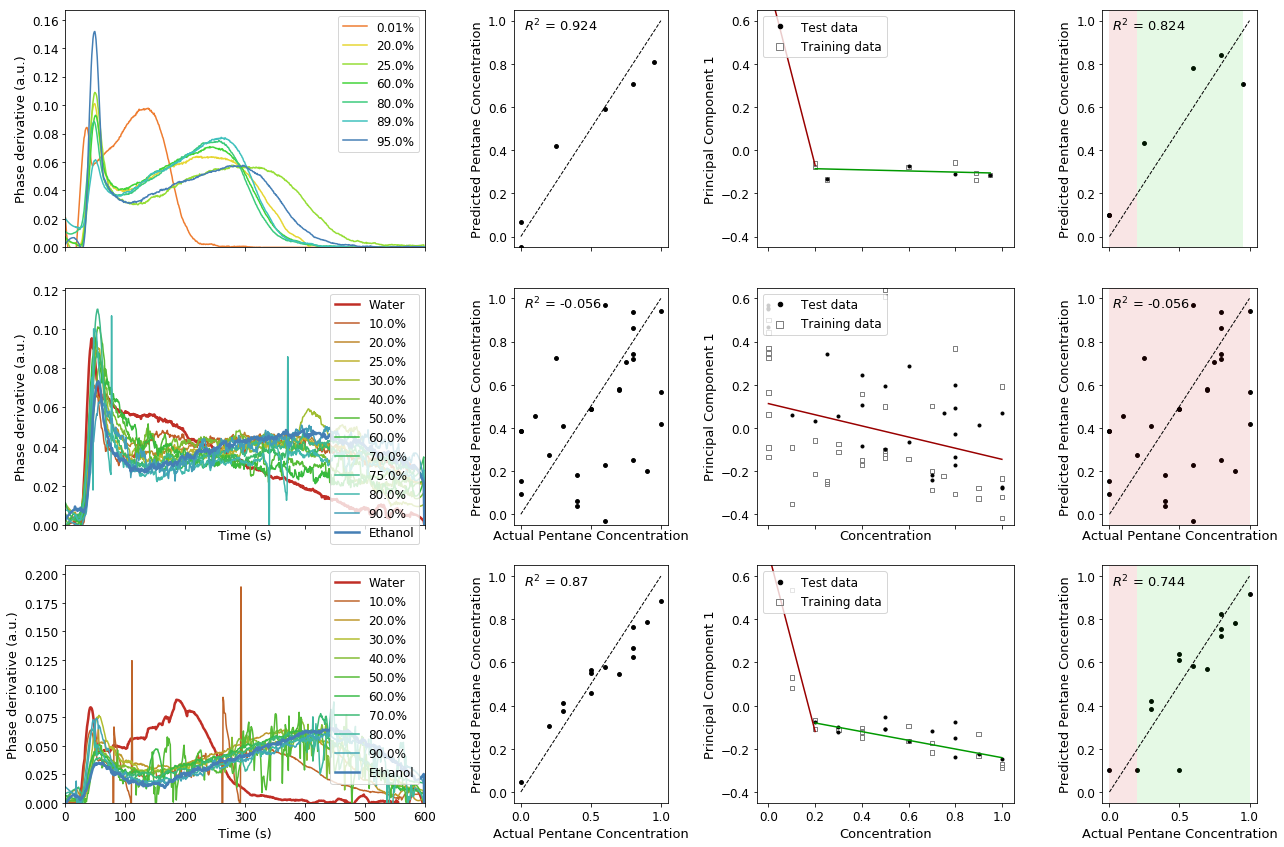

In [120]:
from matplotlib import gridspec
widths = [7, 3, 5, 3]
heights = [4, 4, 4]
fig, ax = plt.subplots(nrows=len(heights), ncols=len(widths), sharex='col', sharey=False, gridspec_kw={'height_ratios': heights, 'width_ratios': widths},figsize=(sum(widths),sum(heights)));
#gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

# divide figure into suplots
#axB = ax[0,:] #[fig.add_subplot(gs[0, c]) for c in range(0,4)]
#axC = ax[1,:] #[fig.add_subplot(gs[-1, c]) for c in range(0,4)]

# add phase derivative plots
plot_derivs(glass_derivs, glass_concentrations, c2=hexane_orange, c1 = pentane_blue, ax = ax[0,0])
plot_derivs(F13_derivs, F13_concentrations, c2=octane_red, c1 = pentane_blue, ax = ax[1,0])
plot_derivs(gradient_derivs, gradient_concentrations, c2=octane_red, c1 = pentane_blue, ax = ax[-1,0])

# add SVR regression plots
plot_regression(glass_test_lbl, SVR['glass'].predict(glass_test), c=color['test'], ax = ax[0,1])
plot_regression(F13_test_lbl, SVR['13F'].predict(F13_test), c=color['test'], ax = ax[1,1])
plot_regression(gradient_test_lbl, SVR['gradient'].predict(gradient_test), c=color['test'], ax = ax[-1,1])

# add segmentation results
plot_segmentation(model['glass'], glass_train, glass_train_lbl, glass_test, glass_test_lbl, initial_colorID = 0, ax = ax[0,2])
plot_segmentation(model['13F'], F13_train, F13_train_lbl, F13_test, F13_test_lbl, initial_colorID = 0, ax = ax[1,2])
plot_segmentation(model['gradient'], gradient_train, gradient_train_lbl, gradient_test, gradient_test_lbl, initial_colorID = 0, ax = ax[-1,2])

# add SVR regression plots with segmentation
plot_regression(glass_test_lbl, predict_multiSVR(model['glass'], glass_test), c='k', model = model['glass'], initial_colorID = 0, ax = ax[0,3])
plot_regression(F13_test_lbl, predict_multiSVR(model['13F'], F13_test), c='k', model = model['13F'], initial_colorID = 0, ax = ax[1,3])
plot_regression(gradient_test_lbl, predict_multiSVR(model['gradient'], gradient_test), c='k', model = model['gradient'], initial_colorID = 0, ax = ax[-1,3])

# Remove xlabels in the first row and space out labels
for n in range(0,len(widths)):
    ax[0,n].set_xlabel('')
plt.tight_layout()